# Auto Encoder MNIST

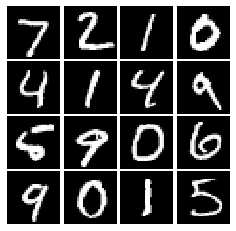

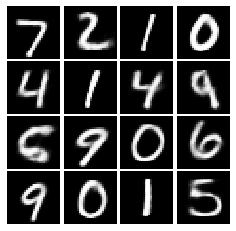

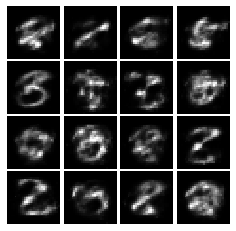

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from copy import deepcopy

import utils

# this line should be commented out for regular python run 
%matplotlib inline  
# this line should be commented out for regular python run 


""" Hyperparameter """
data_size = 60000
batch_size = 100
lr = 1e-3
epoch = 15


""" Data Loading """
def load_mnist_flat():
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train, x_test = x_train / 255.0, x_test / 255.0
    x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
    x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)

    y_train_cls = deepcopy(y_train).astype(np.int32)
    y_test_cls = deepcopy(y_test).astype(np.int32)

    y_train = np.eye(10)[y_train].astype(np.float32)
    y_test = np.eye(10)[y_test].astype(np.float32)

    data = (x_train, x_test, y_train, y_test, y_train_cls, y_test_cls)

    return data

# x_train.shape     :  (60000, 784)
# x_test.shape      :  (10000, 784)
# y_train.shape     :  (60000, 10)
# y_test.shape      :  (10000, 10)
# y_train_cls.shape :  (60000,)
# y_test_cls.shape  :  (10000,)
data = load_mnist_flat()
x_train, x_test, y_train, y_test, y_train_cls, y_test_cls = data


""" Graph Construction """
tf.random.set_random_seed(337)

# placeholders
x = tf.placeholder(tf.float32, shape=(None, 784), name='x')
z = tf.placeholder(tf.float32, shape=(None, 10), name='z')

# weights
E_W1 = tf.get_variable("E_W1", shape=(784, 1000), \
                       initializer=tf.contrib.layers.xavier_initializer())
E_b1 = tf.get_variable("E_b1", shape=(1000, ), \
                       initializer=tf.constant_initializer(0.0))

E_W2 = tf.get_variable("E_W2", shape=(1000, 100), \
                       initializer=tf.contrib.layers.xavier_initializer())
E_b2 = tf.get_variable("E_b2", shape=(100, ), \
                       initializer=tf.constant_initializer(0.0))

E_W3 = tf.get_variable("E_W3", shape=(100, 10), \
                       initializer=tf.contrib.layers.xavier_initializer())
E_b3 = tf.get_variable("E_b3", shape=(10, ), \
                       initializer=tf.constant_initializer(0.0))

D_W1 = tf.get_variable("D_W1", shape=(10, 100), \
                       initializer=tf.contrib.layers.xavier_initializer())
D_b1 = tf.get_variable("D_b1", shape=(100, ), \
                       initializer=tf.constant_initializer(0.0))

D_W2 = tf.get_variable("D_W2", shape=(100, 1000), \
                       initializer=tf.contrib.layers.xavier_initializer())
D_b2 = tf.get_variable("D_b2", shape=(1000, ), \
                       initializer=tf.constant_initializer(0.0))

D_W3 = tf.get_variable("D_W3", shape=(1000, 784), \
                       initializer=tf.contrib.layers.xavier_initializer())
D_b3 = tf.get_variable("D_b3", shape=(784, ), \
                       initializer=tf.constant_initializer(0.0))

def encoding(x, E_W1, E_b1, E_W2, E_b2, E_W3, E_b3):
    h1 = tf.nn.relu(tf.matmul(x, E_W1) + E_b1)
    h2 = tf.nn.relu(tf.matmul(h1, E_W2) + E_b2)
    z = tf.nn.relu(tf.matmul(h2, E_W3) + E_b3)
    return z

def decoding(z, D_W1, D_b1, D_W2, D_b2, D_W3, D_b3):
    h1 = tf.nn.relu(tf.matmul(z, D_W1) + D_b1)
    h2 = tf.nn.relu(tf.matmul(h1, D_W2) + D_b2)
    logits = tf.matmul(h2, D_W3) + D_b3
    probs = tf.nn.sigmoid(logits)
    return logits, probs

# encoding and decoding of x
z_x = encoding(x, E_W1, E_b1, E_W2, E_b2, E_W3, E_b3)
logits_x, probs_x = decoding(z_x, D_W1, D_b1, D_W2, D_b2, D_W3, D_b3)

# reconstructed images
x_recon = probs_x

# cost and optimizer
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_x, \
                                                        labels=x)
cost = tf.reduce_mean(cross_entropy)
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

# generated images
logits_z, probs_z = decoding(z, D_W1, D_b1, D_W2, D_b2, D_W3, D_b3)
x_generated = probs_z


""" Train """
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    # run gradient descent
    for i in range(epoch):
        x_data = x_train
        idx = np.random.permutation(np.arange(data_size)) 
        x_batch = x_data[idx]
        for batch_number in range(int(data_size/batch_size)): 
            x_b = x_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            feed_dict = {x: x_b}
            _, cost_now = sess.run([train_op, cost], feed_dict=feed_dict)
            #print(cost_now)
        
    # visualization_of_reconstruction:
    imgs_original = x_test[0:16, :]
    feed_dict = {x: imgs_original}
    imgs_recon = sess.run(x_recon, feed_dict=feed_dict)
    
    fig = utils.plot_16_images_2d_and_returen(imgs_original, img_shape=(28,28))
    plt.show(fig)
    
    fig = utils.plot_16_images_2d_and_returen(imgs_recon, img_shape=(28,28))
    plt.show(fig)
    
    # plot_16_generated_images
    feed_dict = {z: np.random.normal(0, 1, size=(16, 10))}
    imgs_generated = sess.run(x_generated, feed_dict=feed_dict)

    fig = utils.plot_16_images_2d_and_returen(imgs_generated, img_shape=(28,28))
    plt.show(fig)